# Building a Deep Neural Network
<hr>

A DNN can be decomposed as the following sequence of operations:
* Input Data
* Forward Propagation to obtain an Output Data
* Evaluate Output Data (compute current Cost)
* Given current Cost, do Back-propagation to update weights
* Repeat from beggining with updated weights

In [1]:
%%capture
%run shapesdata.ipynb

# Loading the data (circle, square and triangle drawings)
train_x_orig, train_y_orig, test_x_orig, test_y_orig, _, _ = load_data()

This is a ['triangle']


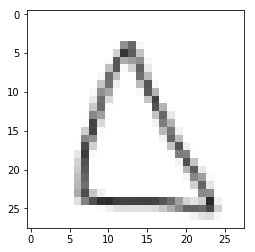

In [2]:
# Example of a drawing and its label
print_img(train_x_orig, train_y_orig, 12)

In [3]:
# Lets see what are the shapes of our variables
print("train_x_orig: {}".format(train_x_orig.shape))
print("train_y_orig: {}".format(train_y_orig.shape))
print("test_x_orig: {}".format(test_x_orig.shape))
print("test_y_orig: {}".format(test_y_orig.shape))

train_x_orig: (210, 28, 28, 3)
train_y_orig: (210, 1)
test_x_orig: (90, 28, 28, 3)
test_y_orig: (90, 1)


## Lets prepare our data

### One example by column
We can arrange our example either by rows or by columns. Here we choose to arrange them by columns.

### Flattening images
First, we need to flatten our images, since they are actually arrays and we want them to be vectors. Our **train_x_orig** and **test_x_orig** variables are arrays with shape **(210, 28, 28, 3)**, where the first number stands for the number of examples we have in the set and the remaining three number are a single image array. We want them to be arrays of shape **(28\*28\*3, 210)**, so we use numpy's reshape method.

In [53]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

### Standardize data to have feature values between 0 and 1

In [157]:
train_x = train_x_flatten/255
test_x = test_x_flatten/255

### Check the shapes

In [156]:
print("train_x: {}".format(train_x.shape))
print("test_x: {}".format(test_x.shape))

train_x: (2352, 210)
test_x: (2352, 90)


### One hot encoding the labels vectors
Our **train_y_orig** and **test_y_orig** variables are arrays with shape **(210, 1)**, i.e. column vectors, and to each example there is an associate class indicated by a string, i.e. 'circle'. However, we want this classes to be indicated by numbers and the best way to do that is by a process called **one hot encoding**:
* We define a vector whose each component corresponds to a class, and we indicate that our example belongs to a certain class by filling this vector with zeros except for the corresponding class component, which we fill with 1.
* To each example, then, we associate one of this vectors.

After one hot encoding train_y_orig and test_y_orig we should have labels vectors **train_y** and **test_y** of shape **(3, 210)** and **(3, 90)**.

In [159]:
def onehotencode(y):
    
    classes = np.unique(y)
    
    one_hot_y = np.zeros((len(y[0]), len(classes)))
    
    for i, item in enumerate(y[0]):   
        one_hot_y[i] = item == classes

    one_hot_y = one_hot_y.T
    
    return one_hot_y

train_y = onehotencode(train_y_orig)
test_y = onehotencode(test_y_orig)

### Final check of shapes

In [161]:
# Lets see what are the new shapes of our variables
print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x: {}".format(test_x.shape))
print("test_y: {}".format(test_y.shape))

train_x: (2352, 210)
train_y: (3, 210)
test_x: (2352, 90)
test_y: (3, 90)


## Defining the model, i.e. the NN architecture
<hr>

* Lets denote the number of features of an example by **n_x**
* Lets denote the number of classes we can classify to by **C**
* Lets denote the number of exampels in the training set by **M**

In [162]:
M = train_x.shape[1]                   # Number of examples
n_x = train_x.shape[0]                 # Number of features
C = 3                                  # Number of classes
hidden_layers = [20, 7, 5]             # Number of hidden layers and their respective size

layer_dims = [n_x, *hidden_layers, C] # Neural Network Architecture

## Initializing the parameters

In [592]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
                  including the dimension of the input and the output
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(42)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

parameters = initialize_parameters(architecture)

## Defining activation functions

In [358]:
def sigmoid(x):
    
    s = 1/(1+np.exp(-x))
#     cache = x
    
    return s

def relu(x):
    e = 0.01
    r = np.maximum(e*x,x)
#     cache = x
    
    return r

def softmax(x):
    
    x_exp = np.exp(x)

    x_sum = np.sum(x_exp, axis = 0, keepdims = True)
    
    s = x_exp/x_sum
    
    return s

## Forward Propagation

We know that when going from the layer $l-1$ to the layer $l$ we do the following:
\begin{equation}
    Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]},
\end{equation}
then
\begin{equation}
    A^{[l]} = g^{[l]}(Z^{[l]}),
\end{equation}
so let's write a code to perform this steps, bearing in mind that we will use them inside the main iteration loop.

* Lets denote $A^{[l-1]}$ by **A_prev**

In [234]:
def step_forward(A_prev, W, b, activation_function = "relu"):
    """
    Implement a layer's forward propagation step.

    Arguments:
        A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
        Z -- the input of the activation function, also called pre-activation parameter 
        cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W @ A_prev + b
    
    assert(Z.shape == (W.shape[0], A_prev.shape[1])) # This line checks the dimensions of Z
    
    if activation_function == 'relu':
        A = relu(Z)
        
    if activation_function == 'sigmoid':
        A = sigmoid(Z)
        
    if activation_function == 'softmax':
        A = softmax(Z)
        
    assert (A.shape == Z.shape) # This line checks the dimensions of A, which should be the same as of Z

        
    cache = (A_prev, W, b, Z)
    
#     return Z, cache
    return A, cache

In [166]:
# Testing the function
A = np.array([[.1,.2],[.5,.4]])
W = np.array([[.2,.3],[.4,.3],[.1, .3]])
b = np.array([[.1,.1],[.2,.2],[.3,.3]])

step_forward(A, W, b, 'softmax')

array([[0.29969313, 0.29873118],
       [0.33790306, 0.34362265],
       [0.3624038 , 0.35764616]])

In [397]:
def forward_propagation(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
    caches = []
    
    A = X
    L = len(parameters) // 2     # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        
        A, cache = step_forward(A_prev, W, b, 'relu')
#         print(A.T[l])
        caches.append(cache)
        
    A_prev = A
    W = parameters["W"+str(L)]
    b = parameters["b"+str(L)]
    
    AL, cache = step_forward(A_prev, W, b, 'softmax')
#     print(AL.T[l])
    caches.append(cache)
        
    assert(AL.shape == (C, X.shape[1]))
                
    return AL, caches

AL, caches = forward_propagation(train_x, parameters)

In [386]:
AL.T[0]

array([0.12585737, 0.21361025, 0.66053238])

## Computing the current Cost

In [327]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    # Compute loss from aL and y.
    x = np.log(AL)
    a = Y*np.log(AL)
#     print(a.shape)
    loss = np.sum(a, axis = 0)
    cost = (-1)*(1/M)*np.sum(loss)
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    assert(cost.shape == ())
    
    return cost

In [394]:
cost = compute_cost(AL, train_y)
cost

1.0987873841165654

## Backpropagation

In [359]:
def softmax_derivative(z):
    x = softmax(z)
    return np.multiply(x,(1-x))

def sigmoid_derivative(z):
    x = sigmoid(z)
    return np.multiply(x,(1-x))

def relu_derivative(z):
    x = np.zeros(z.shape)
    x[z > 0] = 1
    x[z <= 0] = 0.01
    return x

In [216]:
def backward_step(dA, A_prev, W, b, Z, activation_function = "relu"):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    if activation_function == 'relu': 
        dZ = np.multiply(dA, relu_derivative(Z))
        
    if activation_function == 'sigmoid': 
        dZ = np.multiply(dA, sigmoid_derivative(Z))
        
    if activation_function == 'softmax': 
        dZ = np.multiply(dA, softmax_derivative(Z))
    
    dW = (1/M)*(dZ @ A_prev.T)
    
    db = (1/M)*np.sum(dZ, axis = 1, keepdims = True)
    
    dA_prev = W.T @ dZ
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [391]:
def backward_propagation(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    dAL = AL - Y
        
    dA = dAL
    
    A_prev, W, b, Z = caches[L-1]
    
    dA_prev, dW, db = backward_step(dA, A_prev, W, b, Z, 'softmax')
    
    grads["dA" + str(L-1)] = dA_prev
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(0, L-1)):   # Note that the first value "l" takes is L-2 
        
        dA = grads["dA" + str(l+1)]  # Note that the first index used is "l+1" = L-1, whish follows the L we used
        A_prev, W, b, Z = caches[l]
    
        dA_prev, dW, db = backward_step(dA, A_prev, W, b, Z, 'relu')

        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l+1)] = dW
        grads["db" + str(l+1)] = db

    return grads

grads = model_backward(AL, train_y, caches)


In [392]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters

parameters = update_parameters(parameters, grads, 0.01)

In [589]:
def deep_model(X, Y, dev_x, dev_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(42)
    train_errors = []                         # keep track of train error
    test_errors = []                          # keep track of train error
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward_propagation(X, parameters)
        
        dev_AL, _ = forward_propagation(dev_x, parameters)
        
        # Compute cost.
        train_error = compute_cost(AL, Y)
        
        test_error = compute_cost(dev_AL, dev_y)
    
        # Backward propagation.
        grads = backward_propagation(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, train_error))
        if print_cost and i % 1000 == 0:
            train_errors.append(train_error)
        if print_cost and i % 1000 == 0:
            test_errors.append(test_error)
        
    # plot the cost
#     plt.plot(np.squeeze(train_errors))
#     plt.plot(np.squeeze(test_errors))
#     plt.ylabel('cost')
#     plt.xlabel('iterations (per tens)')
#     plt.title("Learning rate =" + str(learning_rate))
#     plt.show()
    
    return parameters, grads

In [550]:
def predict(X, parameters):
    Yhat, _ = forward_propagation(X, parameters)
    pred = np.zeros(Yhat.shape).T
    for m in range(Yhat.shape[1]):
        pred[m][np.argmax(Yhat.T[m], axis = 0)] = 1
    return pred.T

In [636]:
def acc_error(train_y, train_pred):
    prod = train_y*train_pred
    verify = np.sum(prod, axis = 0)
    count = np.sum(verify)
    
    percen_acc = count/train_y.shape[1]
    percen_error = 1-percen_acc
    
    percen_acc = np.around(percen_acc,3)
    percen_error = np.around(percen_error,3)
      
#     print(train_pred.T[verify == 0])
#     print(train_y.T[verify == 0])
    
    train_mis = train_pred.T[verify == 0]
    
    return (percen_acc, percen_error)

# train_acc, train_err = acc_error(train_y, train_pred)


In [659]:
num_iter = np.linspace(1000,5000,21)

test_errors = []

for num in num_iter:
    trained_parameters, grads = deep_model(
        train_x, 
        train_y, 
        test_x,
        test_y,
        layers_dims,
        learning_rate = 0.01, 
        num_iterations = int(num), 
        print_cost=False)

    train_pred = predict(train_x, trained_parameters)
    test_pred = predict(test_x, trained_parameters)

    train_acc, train_err = acc_error(train_y, train_pred)
    test_acc, test_err = acc_error(test_y, test_pred)
    
    test_errors.append(test_err)
#     print("With {} iteration, the model achieved a {}% error on the train set.".format(num, train_err*100))
#     print("With {} iteration, the model achieved a {}% error on the test set.".format(num, test_err*100))
#     print("\n")

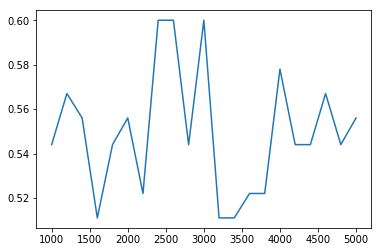

In [660]:
plt.plot(num_iter,test_errors)
plt.show()